In [28]:
import re
import zipfile
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from Bio import SeqIO
import time
from tqdm import tqdm
import csv
import shutil
from scipy.stats import shapiro
import scipy.stats as stats
import numpy as np
from scipy.stats import chi2_contingency
from scipy.stats import spearmanr
from scipy.stats import pearsonr

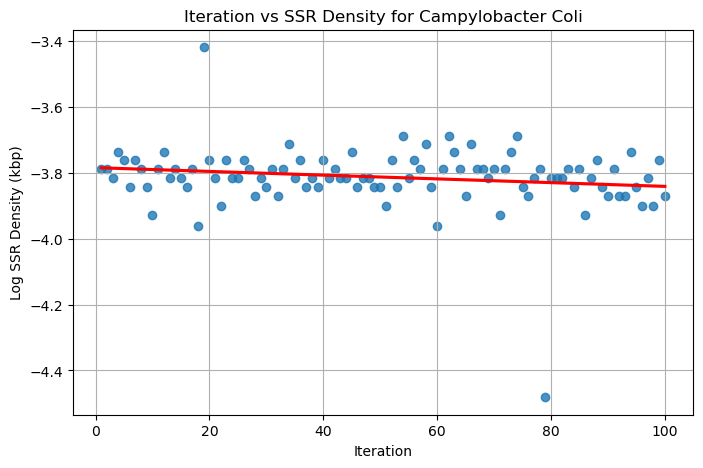

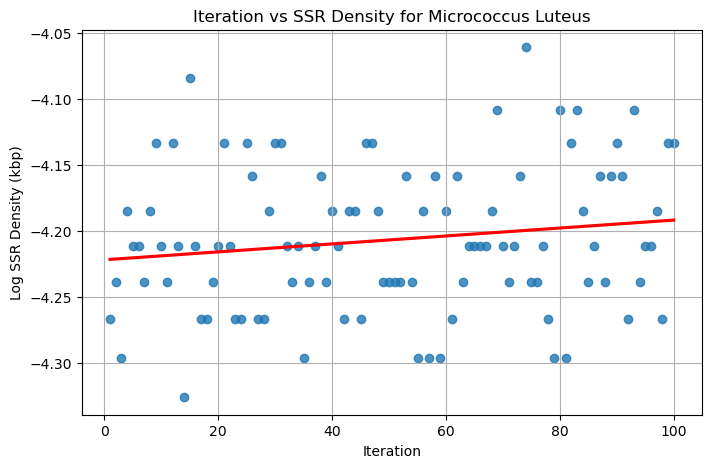

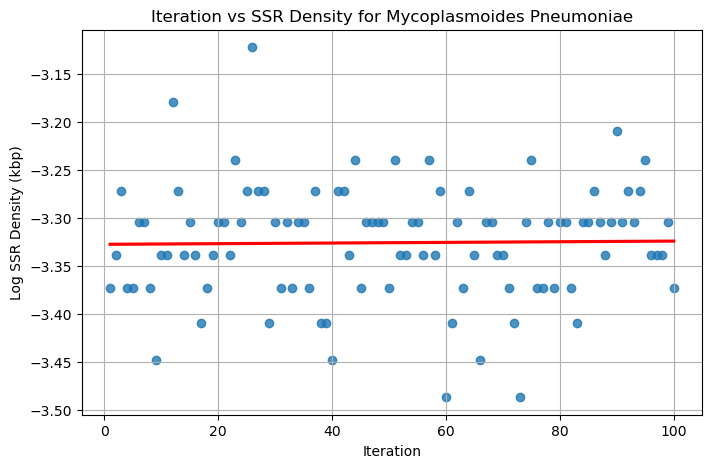

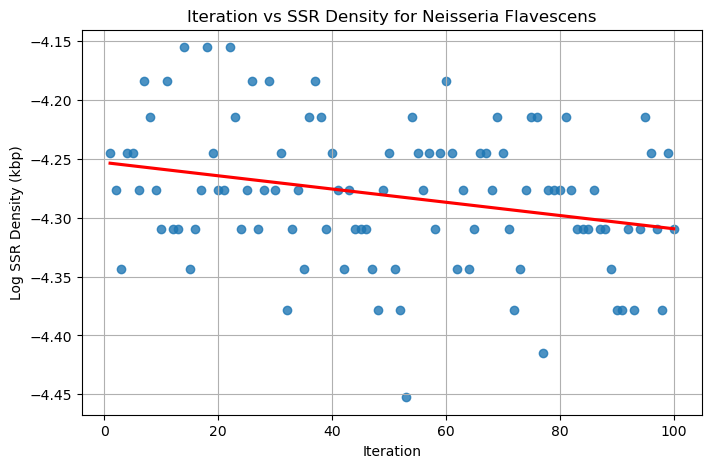

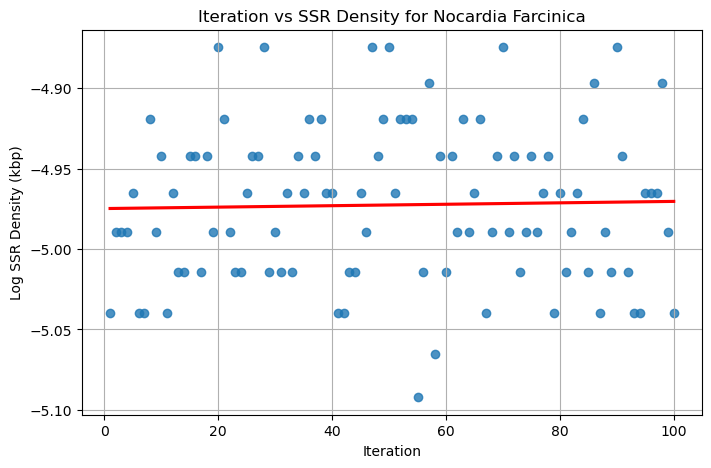

In [4]:
# Load control genomes 
input_files = [
    '/path/to/control/genome1.csv',
    '/path/to/control/genome2.csv',
    '/path/to/control/genome1.csv',
    '/Users/amberlie/controls/neisseriaF.csv',
    '/Users/amberlie/controls/nocardia.csv'
]

# Adjust the name of file to the Genome name
source_names = {
    '/Users/amberlie/controls/campylobacter.csv': 'Campylobacter Coli',
    '/Users/amberlie/controls/micrococcus.csv': 'Micrococcus Luteus',
    '/Users/amberlie/controls/mycoplas.csv': 'Mycoplasmoides Pneumoniae',
    '/Users/amberlie/controls/neisseriaF.csv': 'Neisseria Flavescens',
    '/Users/amberlie/controls/nocardia.csv': 'Nocardia Farcinica'
}

# Define genome size to calculate SSR density (in base pairs)
# Replace with the sizes of your control genomes
genome_sizes = {
    'Campylobacter Coli': 1678432,  
    'Micrococcus Luteus': 2495693,
    'Mycoplasmoides Pneumoniae': 817125,
    'Neisseria Flavescens': 2231882,
    'Nocardia Farcinica': 6021225
}

# Output CSV file where the combined data will be saved
output_file = '/Users/amberlie/controls/totalcontroldata.csv'

# Initialize an empty DataFrame to store the combined data from all files
combined_data = pd.DataFrame()

# Loop through each control genome file
for file in input_files:
    # Read the file into a DataFrame
    df = pd.read_csv(file)
    
    # Extract the Iteration and Total SSR Count columns
    temp_df = df[['Iteration', 'Total SSR Count']].copy()
    
    # Get the source name and genome size corresponding to this file
    source_name = source_names[file]  # Get the name of the genome (from source_names dictionary)
    genome_size = genome_sizes[source_name]  # Get the genome size from the genome_sizes dictionary
    
    # Add source and genome size columns to the temporary DataFrame
    temp_df['Source'] = source_name
    temp_df['Genome Size'] = genome_size
    
    # Calculate SSR Density (SSRs per kilobase of genome)
    temp_df['SSR Density'] = temp_df['Total SSR Count'] / (genome_size / 1000)
    
    # Append the processed data from this file to the combined DataFrame
    combined_data = pd.concat([combined_data, temp_df], ignore_index=True)

# Save the combined data to a new CSV file
combined_data.to_csv(output_file, index=False)

# Now calculate the Log of SSR Density for each row in the combined_data DataFrame
combined_data['Log SSR Density (ln)'] = np.log(combined_data['SSR Density'].replace(0, np.nanmin(combined_data['SSR Density'][combined_data['SSR Density'] > 0]) / 10))

# Plot the SSR Density (log-transformed) against Iteration for each source/genome
for source, group in combined_data.groupby('Source'):
    plt.figure(figsize=(8, 5))
    sns.regplot(x='Iteration', y='Log SSR Density (ln)', data=group, ci=None, line_kws={'color': 'red'})
    plt.title(f"Iteration vs SSR Density for {source}")
    plt.xlabel('Iteration')
    plt.ylabel('Log SSR Density (kbp)')
    plt.grid(True)
    plt.show()

In [6]:
combined_file = '/Users/amberlie/controls/totalcontroldata.csv'
df = pd.read_csv(combined_file)

# Calculate the average Total SSR Count for each Source
average_ssr = df.groupby('Source')['SSR Density'].mean().reset_index()

# Rename columns for clarity
average_ssr.columns = ['Source', 'Average SSR Density']

# Print the result
print(average_ssr)

                      Source  Average SSR Density
0         Campylobacter Coli             0.022181
1         Micrococcus Luteus             0.014918
2  Mycoplasmoides Pneumoniae             0.036004
3       Neisseria Flavescens             0.013845
4         Nocardia Farcinica             0.006934


In [10]:
stats = df.groupby('Source')['SSR Density'].agg(['mean', 'std']).reset_index()

# Rename columns for clarity
stats.rename(columns={'mean': 'Mean SSR Density', 'std': 'Standard Deviation'}, inplace=True)

# Display the calculated statistics
print(stats)

                      Source  Mean SSR Density  Standard Deviation
0         Campylobacter Coli          0.022181            0.001955
1         Micrococcus Luteus          0.014918            0.000831
2  Mycoplasmoides Pneumoniae          0.036004            0.002174
3       Neisseria Flavescens          0.013845            0.000822
4         Nocardia Farcinica          0.006934            0.000338


In [7]:
# Calculate the log odds of the actual genome SSR density against control average SSR density
SDLogOdds_Campylobacter= np.log(0.1227335989780938/0.022181)
SDLogOdds_Micrococcus = np.log(0.1378374663870916/0.014918)
SDLogOdds_Mycoplasmoides = np.log(0.6008872571515986/0.036004)
SDLogOdds_Neisseria = np.log(0.2307469660134362/0.013845)
SDLogOdds_Nocardia = np.log(0.1463157413981374/0.006934)

In [8]:
print(f"The Log odds of the high AT genome Campylobacter Coli is {SDLogOdds_Campylobacter}")
print(f"The Log odds of the high AT genome Mycoplasmoides Pneumoniae is {SDLogOdds_Mycoplasmoides}")
print(f"The Log odds of the high CG genome Micrococcus Luetus is {SDLogOdds_Micrococcus}")
print(f"The Log odds of the high CG genome Nocardia Farcinica is {SDLogOdds_Nocardia}")
print(f"The Log odds of the control genome Neisseria Flavescens is {SDLogOdds_Neisseria}")

The Log odds of the high AT genome Campylobacter Coli is 1.710780077965852
The Log odds of the high AT genome Mycoplasmoides Pneumoniae is 2.8147772814489254
The Log odds of the high CG genome Micrococcus Luetus is 2.223506673692843
The Log odds of the high CG genome Nocardia Farcinica is 3.0493300516814754
The Log odds of the control genome Neisseria Flavescens is 2.8133975683027885


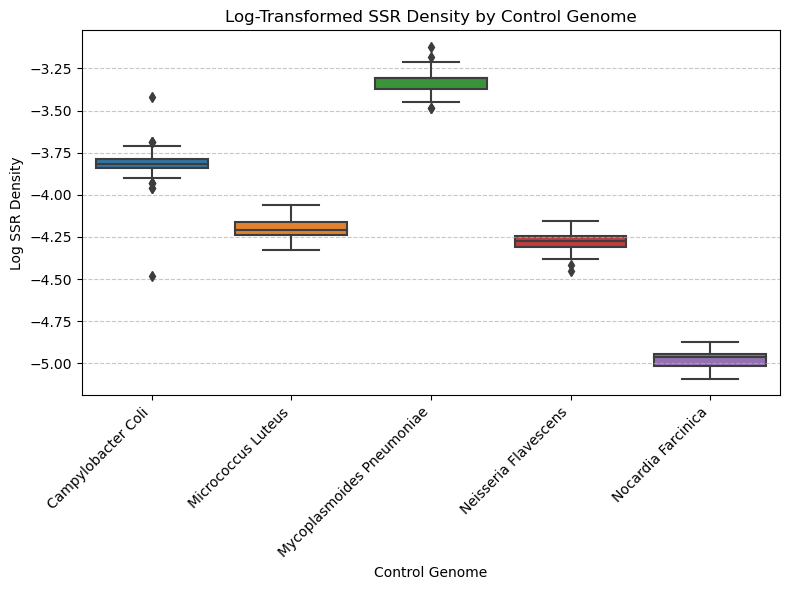

In [9]:
df['Log SSR Density'] = np.log(df['SSR Density'].replace(0, np.nanmin(df['SSR Density'][df['SSR Density'] > 0]) / 10))

# Plot the boxplot for log-transformed SSR Density
plt.figure(figsize=(8, 6))
sns.boxplot(x='Source', y='Log SSR Density', data=df)
plt.xticks(rotation=45, ha='right')
plt.title('Log-Transformed SSR Density by Control Genome')
plt.ylabel('Log SSR Density')
plt.xlabel('Control Genome')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [11]:
# Define the repeat patterns for SSR types
patterns = {
    'Mononucleotide': re.compile(r'^(A+|T+|C+|G+)$'),  # Matches a single base repeated
    'Dinucleotide': re.compile(r'^(.{2})\1+$'),         # Matches any two bases repeated
    'Trinucleotide': re.compile(r'^(.{3})\1+$'),        # Matches any three bases repeated
    'Tetranucleotide': re.compile(r'^(.{4})\1+$'),       # Matches any four bases repeated
    'Pentanucleotide': re.compile(r'^(.{5})\1+$'),       # Matches any five bases repeated
    'Hexanucleotide': re.compile(r'^(.{6})\1+$'),        # Matches any six bases repeated
}

{'Mononucleotide': 13297, 'Dinucleotide': 3661, 'Trinucleotide': 674, 'Tetranucleotide': 20, 'Pentanucleotide': 1, 'Hexanucleotide': 0}


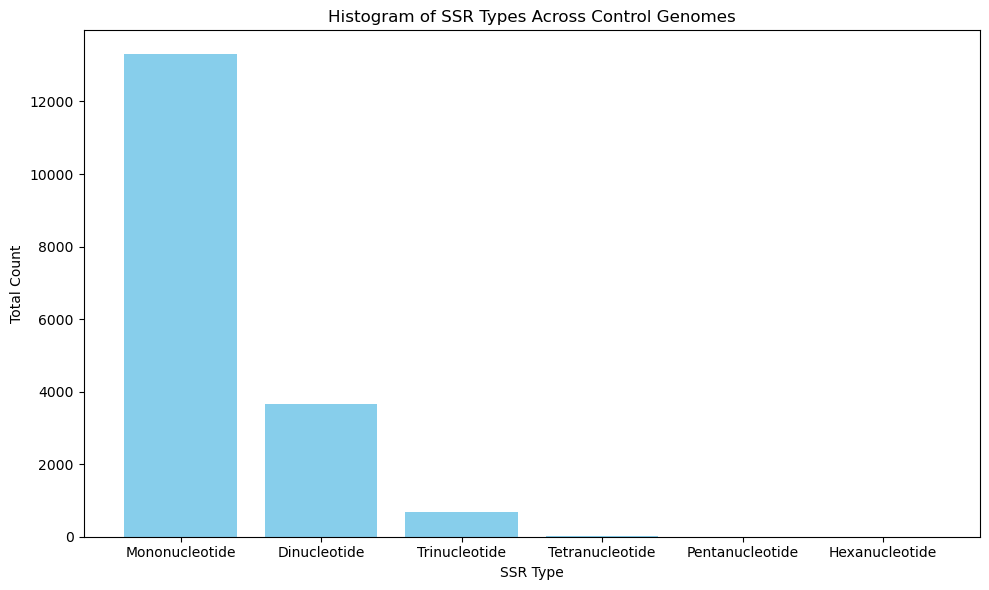

In [12]:
csv_files = [
    '/Users/amberlie/controls/campylobacter.csv',
    '/Users/amberlie/controls/micrococcus.csv',
    '/Users/amberlie/controls/mycoplas.csv',
    '/Users/amberlie/controls/neisseriaF.csv',
    '/Users/amberlie/controls/nocardia.csv'
]

ssr_columns = ['Mononucleotide', 'Dinucleotide', 'Trinucleotide', 'Tetranucleotide', 
               'Pentanucleotide', 'Hexanucleotide']

# Initialize a dictionary to store total SSR counts for each type
total_ssr_counts = {ssr_type: 0 for ssr_type in ssr_columns}

# Process each CSV file
for file in csv_files:
    # Load the CSV
    df = pd.read_csv(file)
    
    # Sum the SSR counts for each type and update the total counts
    for ssr_type in ssr_columns:
        if ssr_type in df.columns:  # Ensure the column exists in the CSV
            total_ssr_counts[ssr_type] += df[ssr_type].sum()

# Check the final structure of total_ssr_counts
print(total_ssr_counts)  # It should be a dictionary like {'Mononucleotide': 100, ...}

# Convert the totals to a DataFrame for easier plotting
ssr_totals_df = pd.DataFrame(list(total_ssr_counts.items()), columns=['SSR Type', 'Total Count'])

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.bar(ssr_totals_df['SSR Type'], ssr_totals_df['Total Count'], color='skyblue')
plt.xlabel('SSR Type')
plt.ylabel('Total Count')
plt.title('Histogram of SSR Types Across Control Genomes')

plt.tight_layout()
plt.show()

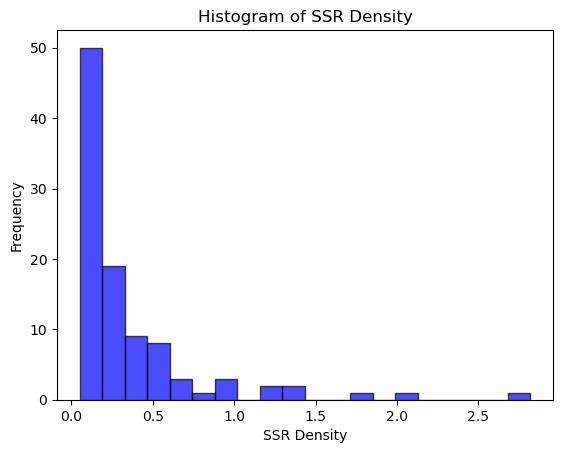

In [16]:
file_path = "/Users/amberlie/data/FYP_data.csv"
data = pd.read_csv(file_path)

# Assess for normality
plt.hist(data['ssr_density'], bins=20, alpha=0.7, color='blue', edgecolor='black')
plt.xlabel('SSR Density')
plt.ylabel('Frequency')
plt.title('Histogram of SSR Density')
plt.show()

In [13]:
folder_path = '/Users/amberlie/ssr_txt_files'

ssr_extraction_pattern = re.compile(r'^SSR: ([ACGT]+), Position: \d+$')

# Initialize a dictionary to store SSRs categorized by file and repeat type
ssrs_by_file = {}

# Function to classify the SSR based on its repeat pattern
def classify_ssr(ssr):
    for category, pattern in patterns.items():
        if pattern.match(ssr):
            return category
    return None  # If no pattern matches, return None

# Process each text file in the folder
for filename in os.listdir(folder_path):
    if filename.endswith('.txt'):  # Only process .txt files
        file_path = os.path.join(folder_path, filename)
        
        # Initialize a nested dictionary for the current file to store SSRs by type
        ssrs_by_file[filename] = { 'Mononucleotide': 0, 'Dinucleotide': 0, 'Trinucleotide': 0,
                                   'Tetranucleotide': 0, 'Pentanucleotide': 0, 'Hexanucleotide': 0 }
        
        with open(file_path, 'r') as file:
            for line in file:
                match = ssr_extraction_pattern.match(line.strip())
                if match:
                    ssr = match.group(1)  # Extract the SSR sequence
                    category = classify_ssr(ssr)  # Classify the SSR based on patterns
                    
                    if category:  # If a category was found, increment the count
                        ssrs_by_file[filename][category] += 1

# Aggregate counts of each SSR type across all files
ssr_counts = { 'Mononucleotide': 0, 'Dinucleotide': 0, 'Trinucleotide': 0,
               'Tetranucleotide': 0, 'Pentanucleotide': 0, 'Hexanucleotide': 0 }

for counts in ssrs_by_file.values():
    for category, count in counts.items():
        ssr_counts[category] += count

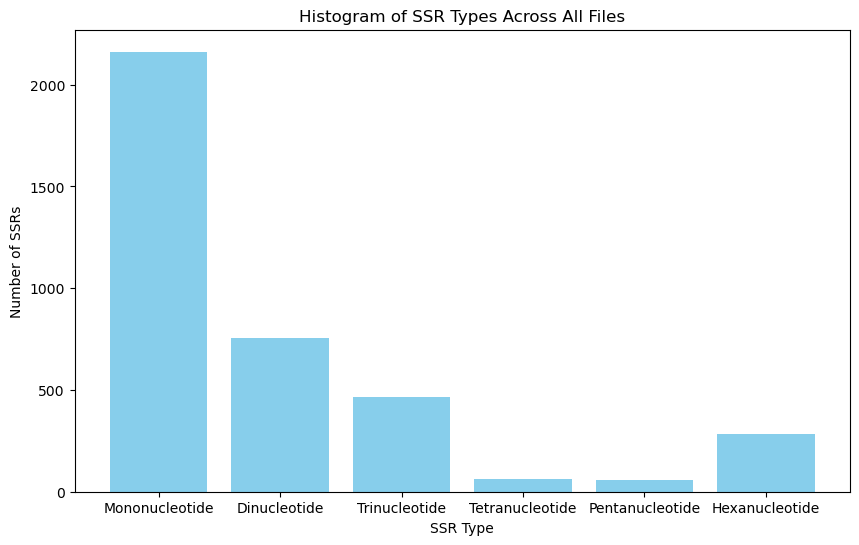

In [14]:
plt.figure(figsize=(10, 6))
plt.bar(ssr_counts.keys(), ssr_counts.values(), color='skyblue')
plt.xlabel('SSR Type')
plt.ylabel('Number of SSRs')
plt.title('Histogram of SSR Types Across All Files')
plt.show()

In [15]:
print(ssr_counts)

{'Mononucleotide': 2162, 'Dinucleotide': 755, 'Trinucleotide': 466, 'Tetranucleotide': 62, 'Pentanucleotide': 56, 'Hexanucleotide': 286}


In [18]:
# Observed frequencies for SSR types in control and actual genomes
observed = [
    [13297, 2179],  # Mononucleotide: [control, actual genome]
    [3661, 761],    # Dinucleotide
    [674, 478],     # Trinucleotide
    [20, 62],       # Tetranucleotide
    [1, 56],        # Pentanucleotide
    [0, 289],       # Hexanucleotide
    [0, 5]          # Other
]

# Perform the Chi-Square Test
stat, p_value, dof, expected = chi2_contingency(observed)

print(f"Chi-Square Statistic: {stat}")
print(f"P-value: {p_value}")
print(f"Degrees of Freedom: {dof}")
print(f"Expected frequencies: \n{expected}")

if p_value < 0.05:
    print("Statistically significant difference in distribution.")
else:
    print("No significant difference in distribution.")

Chi-Square Statistic: 2383.550393177745
P-value: 0.0
Degrees of Freedom: 6
Expected frequencies: 
[[1.27169310e+04 2.75906903e+03]
 [3.63364363e+03 7.88356375e+02]
 [9.46620863e+02 2.05379137e+02]
 [6.73809989e+01 1.46190011e+01]
 [4.68380115e+01 1.01619885e+01]
 [2.37476935e+02 5.15230647e+01]
 [4.10859750e+00 8.91402504e-01]]
Statistically significant difference in distribution.


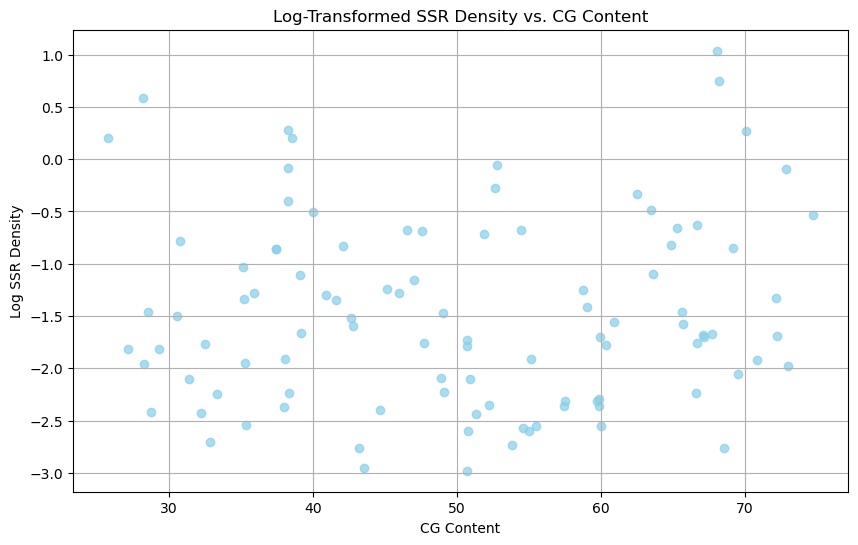

In [19]:
if '%C in bases' in data.columns and '%G in bases' in data.columns and 'ssr_density' in data.columns:
    data['CG_content'] = data['%C in bases'] + data['%G in bases']
    data['log_ssr_density'] = np.log(data['ssr_density'] + 1e-6)

    plt.figure(figsize=(10, 6))
    plt.scatter(data['CG_content'], data['log_ssr_density'], color='skyblue', alpha=0.7)
    plt.xlabel('CG Content')
    plt.ylabel('Log SSR Density')
    plt.title('Log-Transformed SSR Density vs. CG Content')
    plt.grid(True)
    plt.show()
else:
    print('data not available')

In [22]:
data['GC_content'] = data['%C in bases'] + data['%G in bases']
correlation, p_value = spearmanr(data['log_ssr_density'], data['GC_content'])

print(f'Spearman correlation: {correlation}, p-value: {p_value}')

Spearman correlation: 0.051185118511851174, p-value: 0.6130338039541496


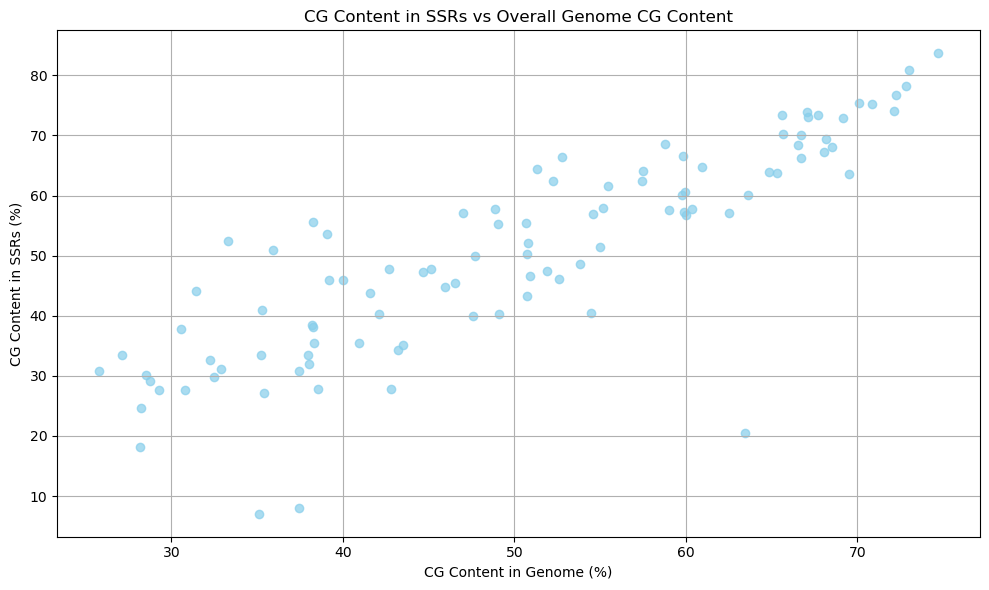

In [23]:
if '%C in bases' in data.columns and '%G in bases' in data.columns:
    data['CG_content'] = data['%C in bases'] + data['%G in bases']
else:
    print('data not available')

if '%C in ssrs' in data.columns and '%G in ssrs' in data.columns:
    data['CG_in_SSRs'] = data['%C in ssrs'] + data['%G in ssrs']
    plt.figure(figsize=(10, 6))
    plt.scatter(data['CG_content'], data['CG_in_SSRs'], color='skyblue', alpha=0.7)
    plt.xlabel('CG Content in Genome (%)')
    plt.ylabel('CG Content in SSRs (%)')
    plt.title('CG Content in SSRs vs Overall Genome CG Content')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print('data not available')

In [29]:
# Calculate correlation between CG Content in Genome and CG in SSRs
correlation, p_value = pearsonr(data['CG_content'], data['CG_in_SSRs'])

print(f"Pearson Correlation: {correlation:.3f}")
print(f"P-value: {p_value:.3e}")

Pearson Correlation: 0.850
P-value: 4.577e-29


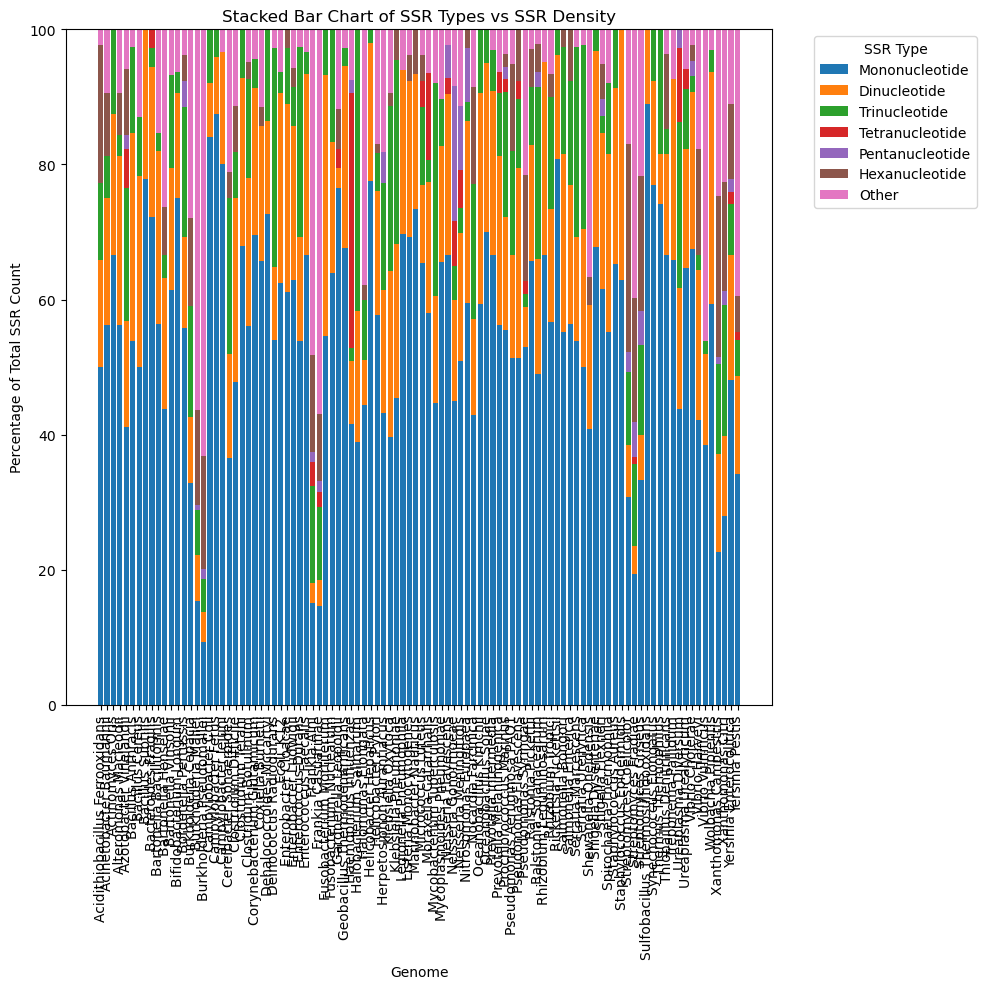

In [31]:
csv_file = '/Users/amberlie/data/FYP_data.csv'
df = pd.read_csv(csv_file)
### df['GC Content'] = df['%C in bases'] + df['%G in bases']
df['Total SSR Count'] = df[['Mononucleotide', 'Dinucleotide', 'Trinucleotide', 'Tetranucleotide', 'Pentanucleotide', 'Hexanucleotide', 'Other']].sum(axis=1)
df['SSR Density'] = df['ssr_density'] # Replace 'genome_size' with the correct column name if different

ssr_columns = ['Mononucleotide', 'Dinucleotide', 'Trinucleotide', 'Tetranucleotide', 
               'Pentanucleotide', 'Hexanucleotide', 'Other']

for col in ssr_columns:
    df[col + ' Percent'] = df[col] / df['Total SSR Count'] * 100

# Plotting the stacked bar chart
plt.figure(figsize=(10, 10))

# Plot a stacked bar chart for SSR types vs SSR density, with SSR density as the y-axis
bar_width = 0.8  # Width of the bars
bottoms = [0] * len(df)  # Initialize bottom positions for stacking

# Plot each SSR type as a separate layer
for i, ssr_type in enumerate(ssr_columns):
    plt.bar(df['Genome'], df[ssr_type + ' Percent'], 
            bottom=bottoms, 
            label=ssr_type, 
            width=bar_width)

    # Update the bottoms for stacking the next layer
    bottoms = [bottom + df[ssr_type + ' Percent'][j] for j, bottom in enumerate(bottoms)]

# Adding labels and title
plt.title("Stacked Bar Chart of SSR Types vs SSR Density")
plt.xlabel("Genome")
plt.ylabel("Percentage of Total SSR Count")
plt.xticks(rotation=90)  # Rotate genome names on x-axis for better readability
plt.legend(title='SSR Type', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()